In [10]:
import numpy as np
import pandas as pd
import pybt
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
from cpymad.madx import Madx
from cpymad.types import Constraint

# Simple example of reverting an injection line geometry

## Background

In this exercise, we flip a simple FODO lattice with some kickers, tilted rbends and some sextupoles. We first ensure that we can revert it and still obtain the same beam profile (but mirrored). We use MADX to transport the Twiss parameters in the backwards direction. A similar exercise of good inspiration from Pablo and Yann can be found here: https://github.com/ydutheil/Transfer_lines_demo/blob/main/eSPS_injection/eSPS_injection.ipynb. However, in this case we explore both cases of reverting only the direction and then direction/x-axis respectively. 

Regarding initial conditions, we first only the direction of the beam and thus all quantities including a $d/ds$. This means that for the initial conditions of the reverted beam, we flip the sign of $\alpha_x$, $\alpha_y$, $p_x$, $p_y$, $dp_x$ and $dp_y$. Now we do not flip the tilt nor angle of any element along the way. 


First define Twiss plotting function:

In [11]:
def plot_twiss(fig, twiss):
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[1, 4, 4])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax3 = fig.add_subplot(gs[2], sharex=ax1)

    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)

    # top plot is synoptic
    ax1.axis('off')
    ax1.set_ylim(-1.2, 1)
    ax1.plot([0, twiss['s'].max()], [0, 0], 'k-')

    for _, row in twiss[twiss['keyword'].str.contains('quadrupole|rbend|sbend')].iterrows():
        if row['keyword'] == 'quadrupole':
            _ = ax1.add_patch(
                mpl.patches.Rectangle(
                    (row['s']-row['l'], 0), row['l'], np.sign(row['k1l']),
                    facecolor='k', edgecolor='k'))
        elif (row['keyword'] == 'rbend' or 
              row['keyword'] == 'sbend'):
            _ = ax1.add_patch(
                mpl.patches.Rectangle(
                    (row['s']-row['l'], -1), row['l'], 2,
                    facecolor='None', edgecolor='k'))

    #2nd plot is beta functions
    ax2.set_ylabel(r'$\beta$ (m)')
    ax2.plot(twiss['s'], twiss['betx'], 'r-',label=r'$\beta_x$')
    ax2.plot(twiss['s'], twiss['bety'], 'b-',label=r'$\beta_y$')    
    ax2.legend()

    #3rd plot is dispersion functions
    ax3.set_ylabel('D (m)')
    ax3.plot(twiss['s'], twiss['dx'], 'r-',label=r'$D_x$', linestyle = 'dotted')
    ax3.plot(twiss['s'], twiss['dy'], 'b-',label=r'$D_y$', linestyle = 'dotted')
    ax3.legend()

    axnames = ax1.twiny()
    axnames.spines['top'].set_visible(False)
    axnames.spines['left'].set_visible(False)
    axnames.spines['right'].set_visible(False)
    ax1.get_shared_x_axes()  

    ticks, ticks_labels = list(), list()
    for keyword in ['quadrupole', 'rbend', 'sbend']:
        sub_twiss = twiss[twiss['keyword'] == keyword]
        ticks += list(sub_twiss['s'])
        ticks_labels += list(sub_twiss.index)

    axnames.set_xticks(ticks)
    axnames.set_xticklabels(ticks_labels, rotation=90)

    ax3.set_xlabel('s (m)')

    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    ax1.set_xlim(twiss['s'].min(), twiss['s'].max())

We start by building up a simple straight 7-cell FODO lattice.

In [12]:
madx = Madx()  #Starting a MAD-X process in the background, add stdout=False as argument to suppress the output 

#Add some beam and magnet parameters 
ncells = 7
mqk, mql, length = 1.0, 0.1, 5.3
htilt = 0.1
madx.beam(particle='proton', pc=1000)

madx.command.sequence.clone('S1', l='{:10.6e}'.format(length*ncells))
madx.elements.marker.clone('s1start', at=0)
madx.elements.marker.clone('s1end', at='{:10.6e}'.format(length*ncells))
madx.command.endsequence()

#Define the magnet types 
madx.command.quadrupole.clone('QF', l=mql, k1=mqk)
madx.command.quadrupole.clone('QD', l=mql, k1=-mqk)
madx.command.sextupole.clone('SF', l = 0.2, k2 = -0.13129)
madx.command.sextupole.clone('SD', l = 0.2, k2 = 0.13129)
madx.command.rbend.clone('dip', l=0.1, angle=10e-3, tilt=0.0)
madx.command.hkicker.clone('hk', l=0.1, hkick=10e-4, tilt=htilt)

#Insert the FODO cells and some rbends 
madx.command.seqedit(sequence='S1')
for cell in range(ncells):
    madx.command.install(element='QF{}'.format(cell+1), class_='QF', at='{:10.6e}'.format(mql/2 + cell*length))
    madx.command.install(element='QD{}'.format(cell+1), class_='QD', at='{:10.6e}'.format(length/2 - mql/2 + cell*length))
    if (cell != 0) and (cell != ncells-1):
        madx.command.install(element='R{}'.format(cell+1), class_='dip', at='{:10.6e}'.format(length/4 + cell*length))
madx.command.endedit()

#Insert the titled kickers and the sextupoles 
madx.command.seqedit(sequence='S1')
madx.command.install(element='kicker1', class_='hk', at='{:10.6e}'.format(3/4*length))
madx.command.install(element='kicker2', class_='hk', at='{:10.6e}'.format(ncells*length - 3/4*length))
madx.command.install(element='SF1', class_='SF', at='{:10.6e}'.format(1/4*length))
madx.command.install(element='SD1', class_='SD', at='{:10.6e}'.format(ncells*length - 1/4*length))
madx.command.endedit()


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.00  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.05.05               +
  + Execution date: 2023.09.10 13:47:11      +
  ++++++++++++++++++++++++++++++++++++++++++++
++++++ info: seqedit - number of elements installed:  19
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
++++++ info: seqedit - number of elements installed:  4
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

In [13]:
#Print the elements in the short sequence nicely
dash = '-' * 60
print('{:<23} {:>12} {:>23}'.format("Element", "Location", "Type"))
print(dash)
for ele in madx.sequence['S1'].elements:
    print('{:<23} {:>12.6f} {:>23}'.format(ele.name, ele.at, ele.base_type.name))

Element                     Location                    Type
------------------------------------------------------------
s1$start                    0.000000                  marker
s1start                     0.000000                  marker
s1end                      37.100000                  marker
s1$end                     37.100000                  marker
qf1                         0.050000              quadrupole
qd1                         2.600000              quadrupole
qf2                         5.350000              quadrupole
qd2                         7.900000              quadrupole
r2                          6.625000                   rbend
qf3                        10.650000              quadrupole
qd3                        13.200000              quadrupole
r3                         11.925000                   rbend
qf4                        15.950000              quadrupole
qd4                        18.500000              quadrupole
r4                      

Good, now we see that the elements have been properly installed in our short section. Let's perform a Twiss and survey command to see how the optics functions and the geography look like. 

In [14]:
#Perform a Twiss command in the forward direction and plot, as well as survey 
madx.use(sequence="S1")
twiss_forward = madx.twiss().dframe()

survey_forward = madx.survey().dframe() 
end_coords = survey_forward.iloc[-1]  #to use later for survey

enter Twiss module
  
iteration:   1 error:   2.574881E-02 deltap:   0.000000E+00
orbit:   2.037652E-02  9.815537E-04  1.670479E-03 -7.930075E-05  0.000000E+00  0.000000E+00
  
iteration:   2 error:   9.818201E-05 deltap:   0.000000E+00
orbit:   2.041604E-02  9.812705E-04  1.664242E-03 -7.853511E-05  0.000000E+00  0.000000E+00
  
iteration:   3 error:   2.614809E-10 deltap:   0.000000E+00
orbit:   2.041604E-02  9.812704E-04  1.664242E-03 -7.853511E-05  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
              37.1                 -0    0.0007753631048        35.91264845 

                q1                dq1            betxmax              dxmax 
      0.2921379307      -0.2930332185        23.07155924       0.6588172119 

             dxrms             xcomax             xcorms                 q2 
      0.5856677017      0.02631592688      0.02178168267       0.3001204435 

               dq2            

/tmp/ipykernel_14931/3499464212.py:36: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax3.plot(twiss['s'], twiss['dx'], 'r-',label=r'$D_x$', linestyle = 'dotted')
/tmp/ipykernel_14931/3499464212.py:37: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  ax3.plot(twiss['s'], twiss['dy'], 'b-',label=r'$D_y$', linestyle = 'dotted')


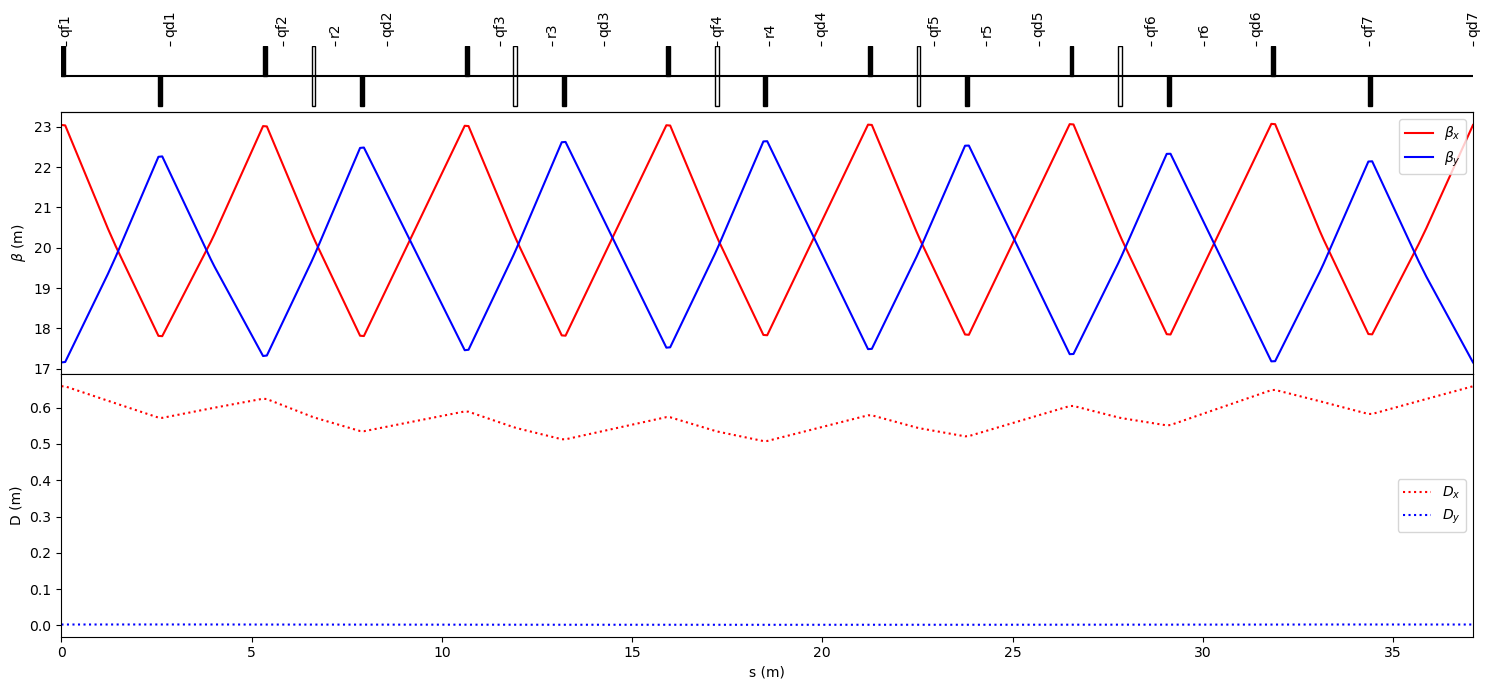

In [15]:
fig = plt.figure(figsize=(15,7))
plot_twiss(fig, twiss_forward)

### Reverse the order in the sequence

We now invert all elements with a `REFLECT` command in MAD-X, and check such that the element order is actually reversed.

In [16]:
madx.command.seqedit(sequence='S1')
madx.command.flatten()
madx.command.extract(sequence='S1', from_='s1start',
             to='s1end',
             newname='S1_flip' )
madx.command.endedit()

madx.command.seqedit(sequence='S1_flip')
madx.command.flatten()
madx.command.reflect()
madx.command.flatten()
madx.command.endedit()

print('{:<23} {:>12}'.format("Element", "Location"))
print(dash)
for ele in madx.sequence['S1_flip'].elements:
    print('{:<23} {:>12.6f}'.format(ele.name, ele.at))

+++ extracting sequence s1 from s1start:1 to s1end:1
+++ new sequence: s1_flip  with current length = 37.1

++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
Element                     Location
------------------------------------------------------------
s1_flip$end                 0.000000
s1end                       0.000000
sd1                         1.325000
qd7                         2.700000
kicker2                     3.975000
qf7                         5.250000
qd6                         8.000000
r6                          9.275000
qf6                        10.550000
qd5          

Perform a Twiss command on the reversed sequence, using the very last Twiss parameters from the unreversed case. However, we need to flip the sign of $\alpha_x$, $\alpha_y$, $p_x$, $p_y$, $dp_x$ and $dp_y$ - the only elements affected by the derivative $d/ds$. We do not flip the tilt nor angle of any element along the way. 

In [17]:
twiss_reversed_start = twiss_forward.iloc[-1]  #the very last element in the forward sequence as starting valus for the reversed sequence

madx.use(sequence="S1_flip")
twiss_reversed = madx.twiss(betx=twiss_reversed_start['betx'], alfx=-twiss_reversed_start['alfx'],
                            bety=twiss_reversed_start['bety'], alfy=-twiss_reversed_start['alfy'], 
                           dx=twiss_reversed_start['dx'], dpx=-twiss_reversed_start['dpx'],
                            dy = twiss_reversed_start['dy'], dpy=-twiss_reversed_start['dpy'],
                            x=twiss_reversed_start['x'], y=twiss_reversed_start['y'],
                            px=-twiss_reversed_start['px'], py=-twiss_reversed_start['py']).dframe()


enter Twiss module
 Found 4 initial orbit vector values from twiss command. 
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   2.041604E-02 -9.812704E-04  1.664242E-03  7.853511E-05  0.000000E+00  0.000000E+00
final orbit vector:     2.041604E-02 -9.812704E-04  1.664242E-03  7.853511E-05 -1.183641E-03  0.000000E+00
++++++ warning: TWCPTK:  The f1010 is bigger than the f1001 in: 24 location, out of 91 in total. The Dqmin estimate might be inaccurate.                                       

++++++ table: summ

            length             orbit5               alfa            gammatr 
              37.1                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
      0.2921378883                  0        23.07155218       0.6588173924 

             dxrms             xcomax             xcorms                 q2 
      0.5856667778      0.02631592688      0.02178168267        0.300120447 

We also perform a survey command of the reversed version, transforming $\phi \rightarrow \phi - \pi$ as we change the longitudinal direction.

In [18]:
survey_reversed = madx.survey(x0 = end_coords.x, y0 = end_coords.y,
                              z0 = end_coords.z,
                              theta0 = end_coords.theta,
                              phi0 = end_coords.phi-np.pi,
                              psi0 = end_coords.psi-np.pi).dframe()

Now we plot the forward Twiss (start) and the backwards (reversed) Twiss to see if the profiles match. 

/tmp/ipykernel_14931/3499464212.py:36: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax3.plot(twiss['s'], twiss['dx'], 'r-',label=r'$D_x$', linestyle = 'dotted')
/tmp/ipykernel_14931/3499464212.py:37: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  ax3.plot(twiss['s'], twiss['dy'], 'b-',label=r'$D_y$', linestyle = 'dotted')


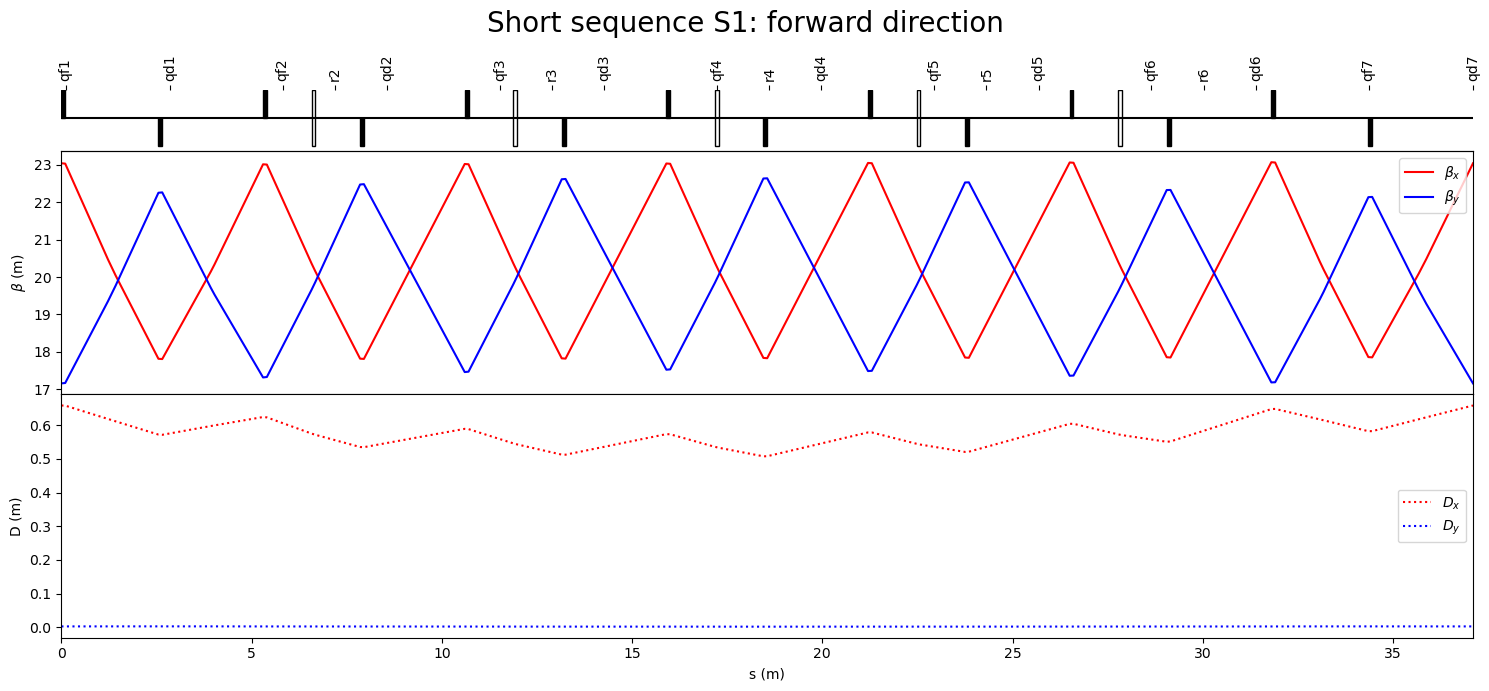

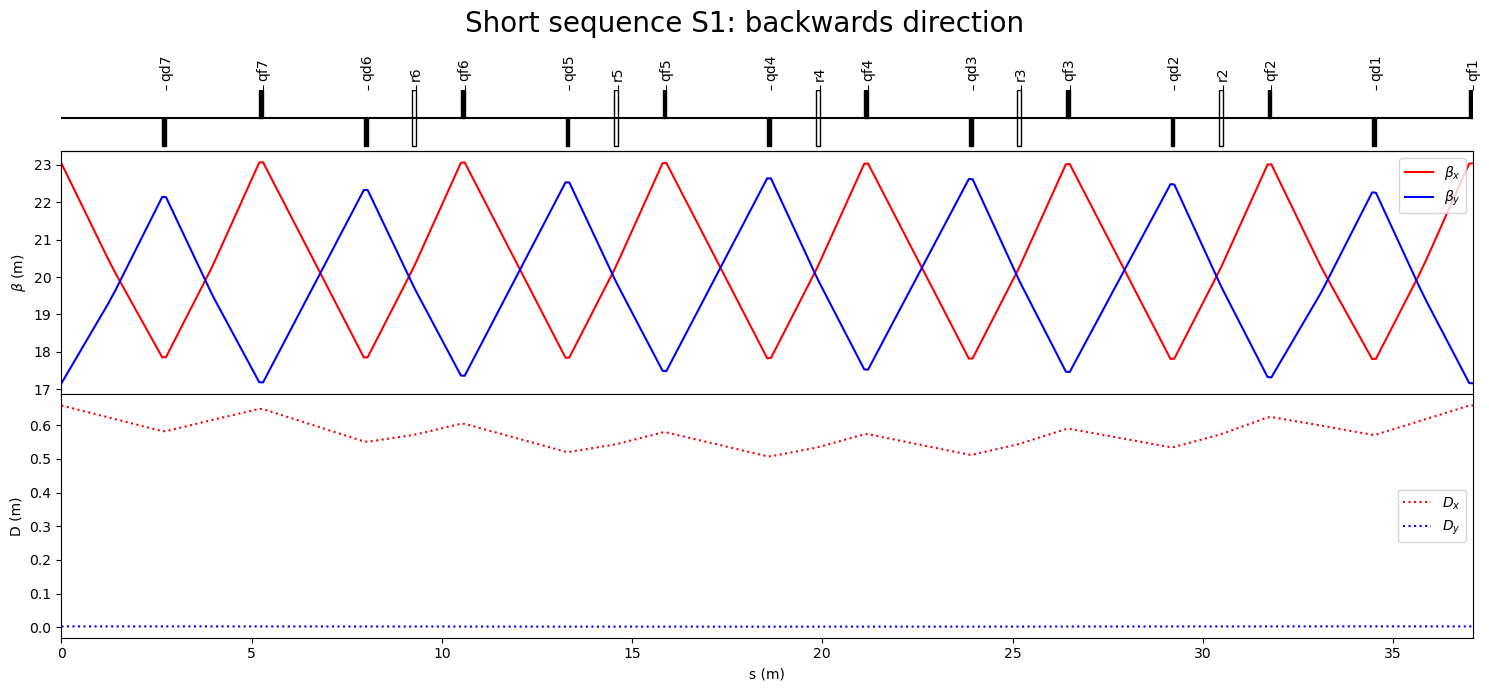

In [19]:
#Forward direction
fig = plt.figure(figsize=(15,7))
fig.suptitle('Short sequence S1: forward direction',fontsize=20)
plot_twiss(fig, twiss_forward)

#Backwards direction
fig = plt.figure(figsize=(15,7))
fig.suptitle('Short sequence S1: backwards direction',fontsize=20)
plot_twiss(fig, twiss_reversed)

We see that both the $\beta$-functions and $D$ are exact mirrors of each other.We also want to extract a survey plot to see how the $x$- and $z$-coordinates (as the $y$- is zero-valued).

Text(0, 0.5, 'z [m]')

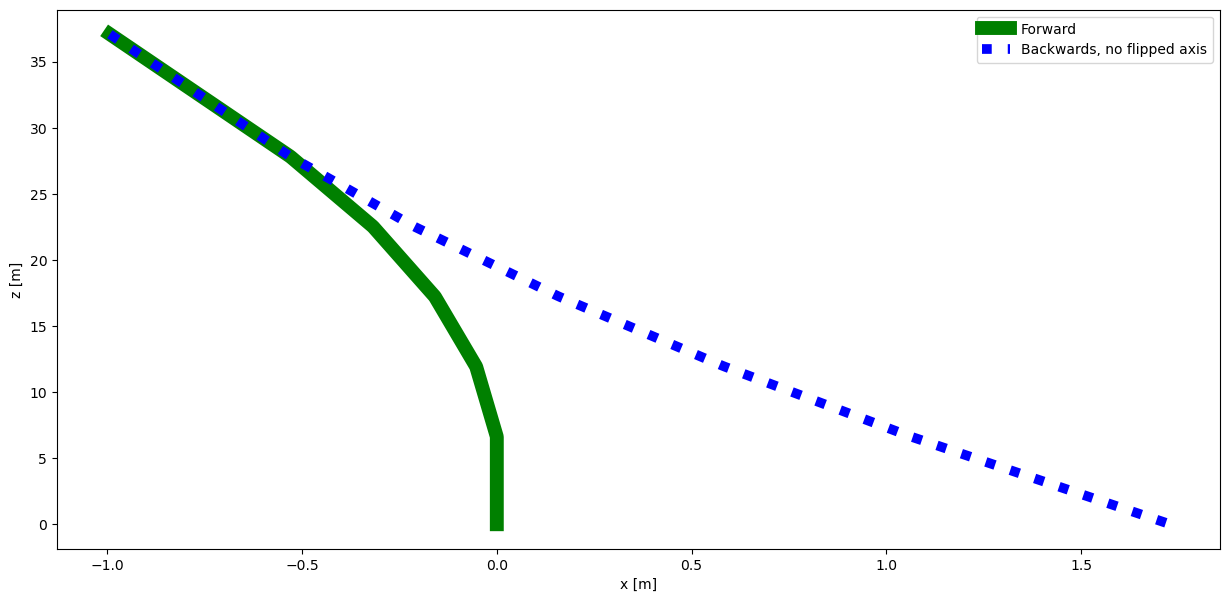

In [20]:
fig = plt.figure(figsize=(15,7))
plt.plot(survey_forward.x, survey_forward.z, color='g',linewidth=10, label='Forward')
plt.plot(survey_reversed.x, survey_reversed.z, color='b', linestyle = 'dotted', linewidth=7, label='Backwards, no flipped axis')
plt.legend()
plt.xlabel('x [m]')
plt.ylabel('z [m]')

Oh oh, something does not seem correct in the survey, as if the beam is steered off in two opposing directions.

### Flipping the $x$- and $s$-axes

We now see that the survey does not overlap, so we also need to revert the $x$-axis as we need to keep a proper right-handed coordinate system. We then need to apply the following transformations 
$$s \rightarrow -s \\ x \rightarrow -x \\ y \rightarrow y $$ 
As we flip also the $x$-axis, we also need to adjust all bending elements. The `TILT` command in MAD-X simply flips the element around the longitudinal axis by a certain angle, so reverting the $x$-axis simply means performing a tilt by $\pi - \theta_{tilt}$ on all bending elements. 

In [21]:
for ele in madx.sequence['S1_flip'].elements:
    try:
        if ele.angle != 0.0:
            ele.tilt = np.pi-ele.tilt
            print('{:<15} {:>12.6f} {:>12.6f} {:>12.6f}'.format(ele.name, ele.at, ele.angle, ele.tilt))
    except:
        print('exception at element {}'.format(ele.name))

exception at element s1_flip$end
exception at element s1end
exception at element sd1
exception at element qd7
exception at element kicker2
exception at element qf7
exception at element qd6
r6                  9.275000     0.010000     0.000000
exception at element qf6
exception at element qd5
r5                 14.575000     0.010000     3.141593
exception at element qf5
exception at element qd4
r4                 19.875000     0.010000     0.000000
exception at element qf4
exception at element qd3
r3                 25.175000     0.010000     3.141593
exception at element qf3
exception at element qd2
r2                 30.475000     0.010000     0.000000
exception at element qf2
exception at element kicker1
exception at element qd1
exception at element sf1
exception at element qf1
exception at element s1start
exception at element s1_flip$start


Also the hkickers need to be flipped, which we do manually as the `hkick` attribute only applies to these two magnets.

In [22]:
madx.sequence['S1_flip'].elements['kicker1']['tilt'] = np.pi-htilt
madx.sequence['S1_flip'].elements['kicker2']['tilt'] = np.pi-htilt

As initial conditions for the Twiss parameters for this case when we flip the $x$- and $s$-axis, we can use the very last Twiss parameter values from the unreversed case. However, we now need to be careful with reverting the Twiss parameters. $\beta$ in both planes will remain the same as before the reversion, but $\alpha$ will not - we need to add a minus sign in both planes for $\alpha$ as the $\beta$ derivatives change due to a sign flip in $d/ds$, as before. 

In this step, we have to be careful, as we revert both the beam direction *and* the x-axis. Thus, $dx$ changes sign $(-1)$ whereas $dy$ is not affected. On the other hand, $dp_x$ remains identical as $(-1) \cdot (-1) = 1$, but $dp_y$ changes sign as direction is changed but not the y-axis!

For the survey, we know that starting the $(x, y, z)$ coordinates are the same as the end coordinates in the forward direction, but we have to perform the transformation $(\theta, \phi - \pi, \psi-\pi)$ to start out in the right angle.

In [23]:
#Use the same initial conditions as in previous case, but with some flipped signs

madx.use(sequence="S1_flip")
twiss_reversed_X = madx.twiss(betx=twiss_reversed_start['betx'], alfx=-twiss_reversed_start['alfx'],
                            bety=twiss_reversed_start['bety'], alfy=-twiss_reversed_start['alfy'], 
                           dx=-twiss_reversed_start['dx'], dpx=twiss_reversed_start['dpx'],
                            dy = twiss_reversed_start['dy'], dpy=-twiss_reversed_start['dpy']).dframe()

survey_reversed_X = madx.survey(x0 = end_coords.x, y0 = end_coords.y,
                              z0 = end_coords.z,
                              theta0 = end_coords.theta,
                              phi0 = end_coords.phi-np.pi,
                              psi0 = end_coords.psi-np.pi).dframe()

enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:    -2.574791E-02  3.942350E-04  2.180317E-03  1.977026E-04 -6.868708E-04  0.000000E+00
++++++ warning: TWCPTK:  The f1010 is bigger than the f1001 in: 24 location, out of 126 in total. The Dqmin estimate might be inaccurate.                                      

++++++ table: summ

            length             orbit5               alfa            gammatr 
              37.1                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
      0.2905897522                  0        23.28575733       0.6588172119 

             dxrms             xcomax             xcorms                 q2 
      0.5727297501      0.02574791341      0.01516783511       0.3015591684 

               dq2            betymax              dymax

Let's plot the Twiss parameters and the survey to see whether we did it right this time:

/tmp/ipykernel_14931/3499464212.py:36: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax3.plot(twiss['s'], twiss['dx'], 'r-',label=r'$D_x$', linestyle = 'dotted')
/tmp/ipykernel_14931/3499464212.py:37: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  ax3.plot(twiss['s'], twiss['dy'], 'b-',label=r'$D_y$', linestyle = 'dotted')


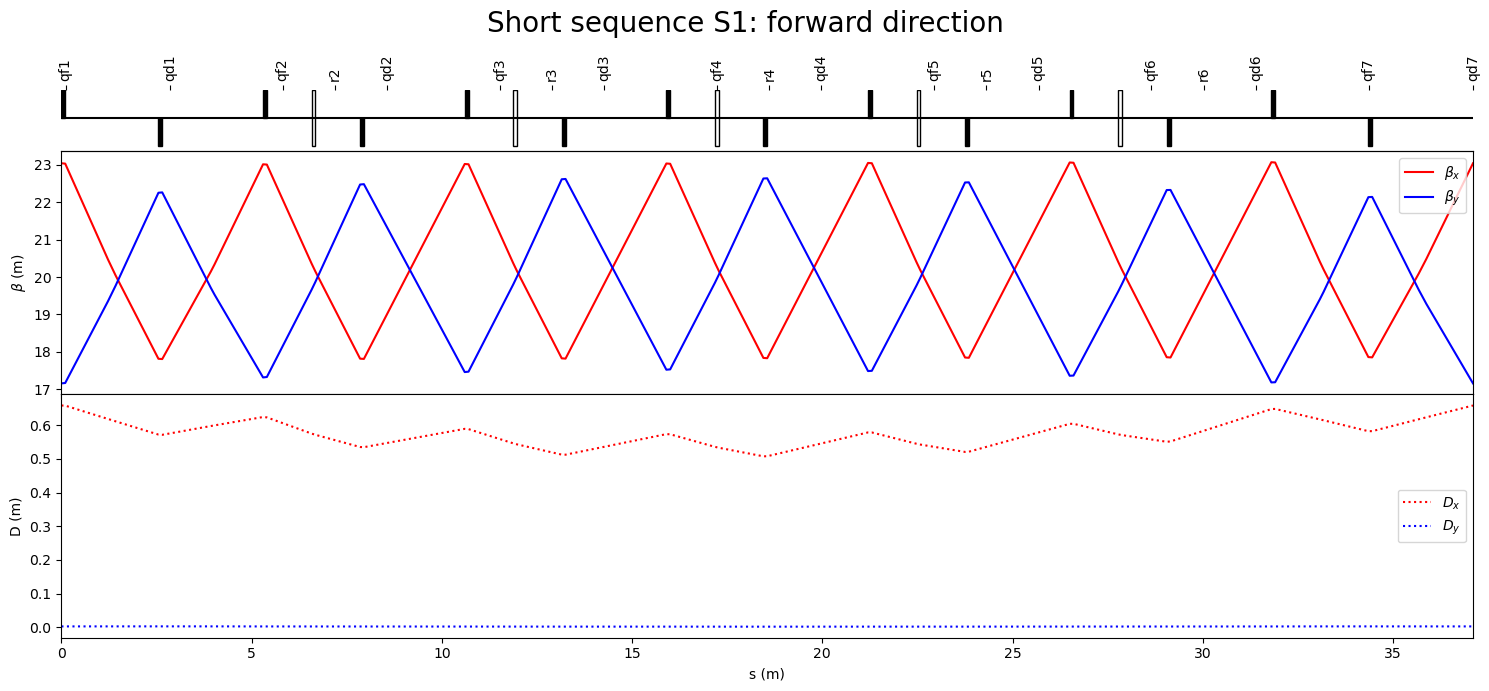

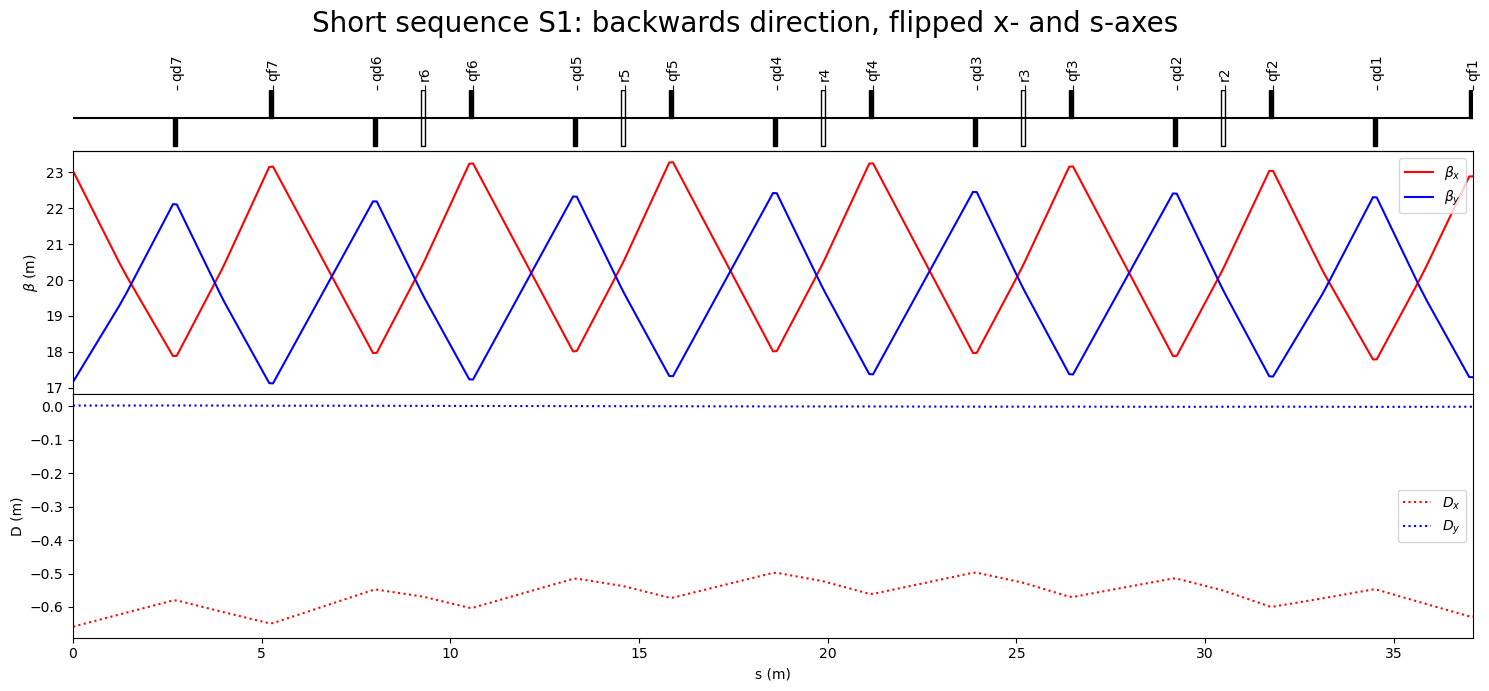

In [24]:
#Forward direction
fig = plt.figure(figsize=(15,7))
fig.suptitle('Short sequence S1: forward direction',fontsize=20)
plot_twiss(fig, twiss_forward)

#Backwards direction
fig = plt.figure(figsize=(15,7))
fig.suptitle('Short sequence S1: backwards direction, flipped x- and s-axes',fontsize=20)
plot_twiss(fig, twiss_reversed_X)

Now the forward and backward Twiss have the same optics propagating in the opposite directions! We revered the x-coordinate which made $D_x$ change sign, but the shape is identical.

Plot the surveys from above to double-check:

Text(0, 0.5, 'z [m]')

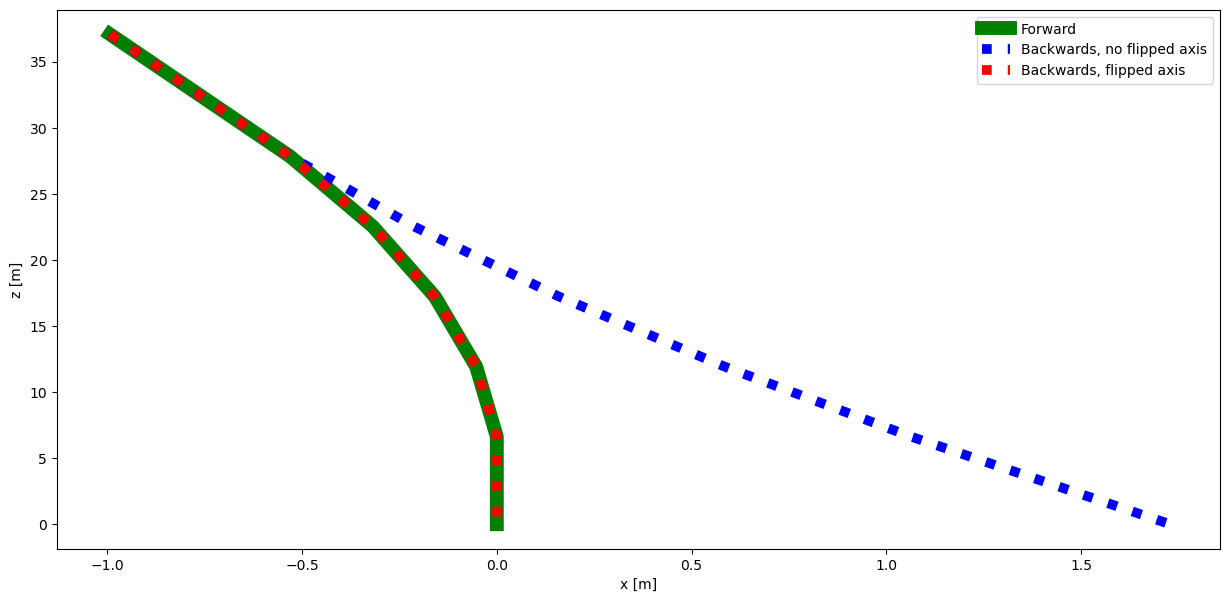

In [25]:
fig = plt.figure(figsize=(15,7))
plt.plot(survey_forward.x, survey_forward.z, color='g', linewidth=10, label='Forward')
plt.plot(survey_reversed.x, survey_reversed.z, color='b', linewidth=7, linestyle = 'dotted', label='Backwards, no flipped axis')
plt.plot(survey_reversed_X.x, survey_reversed_X.z, color='r', linestyle = 'dotted', linewidth=7, label='Backwards, flipped axis')
plt.legend()
plt.xlabel('x [m]')
plt.ylabel('z [m]')

We see now that the `forward` and `reversed_X` survey overlap perfectly as it should!